In [ ]:
#import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import os
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

#### Datos de Google Maps

El control de la calidad de los datos de los archivos de Google Maps se hizo en las notebooks llamadas Metadata_Sitios y Reviews_Estados. </br>
A continuación se detallarán brevemente los hallazgos. </br>

El dataframe Metadata_sitios tenia 3.025.011 filas. No se revisaron si había duplicados ya que el cliente para el que hacemos este análisis solo esta interesado en los datos de restaurantes de pizzerias de los estados de NY y NJ. </br>
Se seleccionaron 23814 filas que tenian categoría 'Pizza restaurant'. La columna address tenia valores como por ejemplo 'Alpine Pizza, 1104 U.S. 9, Schroon Lake, NY 12870' </br>
Se realizaron transformaciones para obtener la direccion, la ciudad, el estado y el codigo postal en columnas independientes para uso futuro.
Se eliminaron algunas columnas. No se modificaron los tipos de datos. </br>
Se seleccionaron los datos de las pizzerias en los estados de NJ y NY. Luego de eliminar 17 filas con datos duplicados, se obtuvieron datos de 3252 pizzerias. </br>
Había 13 locales sin direccion pero tenian los datos de ciudad, estado, latitud y longitud. Por lo que no se eliminaron. </br>
</br>
La columna avg_rating (calificación promedio) tiene un rango de valores de 1.0 a 5.0. La media de calificación promedio es 4.1 . </br>
Se buscaron posibles outliers en la columna num_of_reviews. Se encontraron 4 locales con mas de 1500 reseñas pero se supuso que eran valores posibles.</br>
Se revisaron los valores de las columnas de latitude y longitude usando la librería geopy . Se corrigieron los valores con una diferencia > 0.01.

Se leyeron los datos de reviews de los estados de NY y NJ. </br> 
El dataframe review_estados de NJ tenia 1.950.000 filas. Se encontraron 29.842 reviews duplicadas por las columnas 'user_id', 'gmap_id', 'time' (que formarían la clave de ese archivo). Se eliminaron. </br> 
El dataframe review_estados de NY tenia 2.700.000 filas. También se eliminaron las 59.027 reviews duplicadas para ese estado. </br> 
Cada uno de estos dataframes se unio con el de pizzerias para el departamento de NJ o NY para conocer el nombre del local y los otros datos de cada pizzeria. </br>
Se encontraron 54.045 reseñas para pizzerias del estado de NJ. Y 96.613 reviews para pizzerias del estado de NY. </br>
Se eliminaros de ese dataframe los datos de 737 pizzerias para las que no hubo reseñas en los archivos provistos.

In [84]:
# Leo los archivos con datos de Google Maps
# How to read a Parquet file into Pandas DataFrame?
df_gm_pizza_NJNY = pd.read_parquet('datos/googlemaps/df_mt_pizza_NJNY_202502081554.parquet' , engine='fastparquet')
df_gm_pizza_NJNY_rev = pd.read_parquet('datos/googlemaps/df_pizza_NJNY_rev202502082048.parquet' , engine='fastparquet')

#### Análisis exploratorio de los datos de Google Maps de pizzerías

In [7]:
print(df_gm_pizza_NJNY[['avg_rating' , 'num_of_reviews']].describe())

        avg_rating  num_of_reviews
count  3252.000000     3252.000000
mean      4.110086       89.897909
std       0.508540      142.466030
min       1.000000        1.000000
25%       3.900000       25.000000
50%       4.200000       58.000000
75%       4.500000      118.000000
max       5.000000     4362.000000


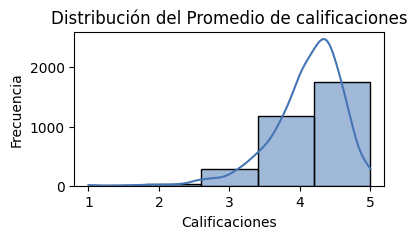

In [43]:
# Distribution of ratings
plt.figure(figsize=(4,2))
sns.histplot(df_gm_pizza_NJNY['avg_rating'], bins=5, kde=True, color='#4575b4')
plt.title("Distribución del Promedio de calificaciones")
plt.xlabel("Calificaciones")
plt.ylabel("Frecuencia")
plt.show()

Las posibles calificaciones estan en un rango de 1 a 5. Como mencionamos antes el promedio de calificaciones para las pizzerias de los estados de NJ y NY es de 4.11 +- 0.5 sugiriendo una tendencia positiva. </br>
Los locales tienen en promedio 89.9 reviews cada uno. Teniendo 1 review el que menos tiene y 4362 reviews el que tiene más.

In [ ]:
print('Estado de NJ: \n', df_gm_pizza_NJNY.loc[df_gm_pizza_NJNY['state'] == 'NJ', ['avg_rating', 'num_of_reviews']].describe() , '\n')
print('Estado de NY: \n', df_gm_pizza_NJNY.loc[df_gm_pizza_NJNY['state'] == 'NY', ['avg_rating', 'num_of_reviews']].describe())

Estado de NJ: 
         avg_rating  num_of_reviews
count  1134.000000     1134.000000
mean      4.116667       96.626984
std       0.499298      129.809335
min       1.000000        1.000000
25%       3.900000       33.000000
50%       4.200000       75.500000
75%       4.500000      128.000000
max       5.000000     2208.000000 

Estado de NY: 
         avg_rating  num_of_reviews
count  2118.000000     2118.000000
mean      4.106563       86.295090
std       0.513502      148.705217
min       1.000000        1.000000
25%       3.900000       18.000000
50%       4.200000       53.000000
75%       4.475000      108.000000
max       5.000000     4362.000000


Si discriminamos por estado vemos que para las pizzerias del estado de NJ el promedio de calificaciones es de 4.11 +- 0.49, similar al promedio de ambos estados. Y tienen un promedio de 96.6 reviews por local.</br>
Para el estado de NY el promedio de calificaciones es levemente menor 4.1 +- 0.5. Y los locales tienen en promedio 86.29 reviews cada uno.

In [ ]:
# Pizza Hut o Pizza Hut Express
print('Estado de NJ: \n', df_gm_pizza_NJNY.loc[(df_gm_pizza_NJNY['state'] == 'NJ') & (df_gm_pizza_NJNY['business_name'].isin(['Pizza Hut', 'Pizza Hut Express'])), ['avg_rating', 'num_of_reviews']].describe() , '\n')
print('Estado de NJ: \n', df_gm_pizza_NJNY.loc[(df_gm_pizza_NJNY['state'] == 'NY') & (df_gm_pizza_NJNY['business_name'].isin(['Pizza Hut', 'Pizza Hut Express'])), ['avg_rating', 'num_of_reviews']].describe())

Estado de NJ: 
        avg_rating  num_of_reviews
count   30.000000        30.00000
mean     3.303333        36.40000
std      0.580418        53.08133
min      1.700000         4.00000
25%      2.825000         8.00000
50%      3.400000        12.00000
75%      3.675000        28.00000
max      4.300000       225.00000 

Estado de NJ: 
        avg_rating  num_of_reviews
count   58.000000       58.000000
mean     3.710345       76.017241
std      0.484384       86.060259
min      2.600000        1.000000
25%      3.425000       17.250000
50%      3.700000       37.500000
75%      3.975000      133.000000
max      5.000000      303.000000


Nuestro cliente, Pizza Hut, tiene un promedio de clasificaciones de 3.3 en NJ y 3.7 en NY

In [28]:
# Las 10 pizzerías con mejor calificacion (mínimo 100 reviews)
top_pizza = df_gm_pizza_NJNY[df_gm_pizza_NJNY['num_of_reviews'] >= 100].sort_values(by='avg_rating', ascending=False).head(10)

# Las 10 pizzerías con menor calificacion (mínimo 100 reviews)
worst_pizza = df_gm_pizza_NJNY[df_gm_pizza_NJNY['num_of_reviews'] >= 100].sort_values(by='avg_rating', ascending=True).head(10)

print("Las 10 mejores pizzerías:\n", top_pizza[['business_name', 'avg_rating', 'num_of_reviews', 'state']], '\n')
print("Las 10 pizzerías con menor calificación:\n", worst_pizza[['business_name', 'avg_rating', 'num_of_reviews', 'state']])


Las 10 mejores pizzerías:
                          business_name  avg_rating  num_of_reviews state
149                   LEO'S PIZZERIA 🍕         4.9             118    NJ
1560          Villa di Como Ristorante         4.9             218    NY
2714                      Zevy's Pizza         4.9             126    NJ
658                   Topo Gigio Pizza         4.9             106    NJ
2304  GoodFellas pizzeria of SunnySide         4.9             488    NY
399                    Curioni's Pizza         4.9             138    NJ
1824                        Dough Vale         4.9             128    NY
1738               Kono Pizza Wildwood         4.8             108    NJ
738          Puterko's Family Pizzeria         4.8             118    NY
2237    Two Brothers Cafe and Pizzeria         4.8             116    NY 

Las 10 pizzerías con menor calificación:
           business_name  avg_rating  num_of_reviews state
972      Domino's Pizza         2.1             398    NY
520   Papa

Si clasificamos las pizzerias de acuerdo a su calificación observamos que las 10 pizzerias mejor calificadas son locales únicos, no pertenecen a una cadena, tienen un promedio entre 4.8 y 4.9 y hay 5 en el estado de NJ y 5 en NY. </br>
Respecto de las pizzerias peor calificadas se observa que su calificación está entre 2.1 y 2.7, pertenecen a dos cadenas muy conocidas (Domino's Pizza y  Papa John's Pizza) y 7 son del estado de NY.

In [ ]:
# Las 10 pizzerías con mejor calificacion (mínimo 50 reviews)
top_pizza = df_gm_pizza_NJNY[ (df_gm_pizza_NJNY['num_of_reviews'] >= 50) & (df_gm_pizza_NJNY['business_name'].isin(['Pizza Hut', 'Pizza Hut Express'])) ].sort_values(by='avg_rating', ascending=False).head(10)

# Las 10 pizzerías con menor calificacion (mínimo 50 reviews)
worst_pizza = df_gm_pizza_NJNY[(df_gm_pizza_NJNY['num_of_reviews'] >= 50) & (df_gm_pizza_NJNY['business_name'].isin(['Pizza Hut', 'Pizza Hut Express'])) ].sort_values(by='avg_rating', ascending=True).head(10)

print("Las 10 mejores pizzerías:\n", top_pizza[['business_name', 'avg_rating', 'num_of_reviews', 'state']], '\n')
print("Las 10 pizzerías con menor calificación:\n", worst_pizza[['business_name', 'avg_rating', 'num_of_reviews', 'state']])

Las 10 mejores pizzerías:
           business_name  avg_rating  num_of_reviews state
690           Pizza Hut         4.3             248    NY
2477          Pizza Hut         4.3              67    NY
3014          Pizza Hut         4.2              88    NY
3187          Pizza Hut         4.0             208    NY
2900          Pizza Hut         4.0             149    NY
1133          Pizza Hut         3.9             303    NY
2172          Pizza Hut         3.9              68    NJ
207   Pizza Hut Express         3.8             182    NY
2500          Pizza Hut         3.7             178    NY
2901          Pizza Hut         3.7             168    NY 

Las 10 pizzerías con menor calificación:
      business_name  avg_rating  num_of_reviews state
2625     Pizza Hut         2.7              54    NY
1196     Pizza Hut         2.9              68    NJ
1586     Pizza Hut         3.2              78    NY
829      Pizza Hut         3.2             148    NY
3081     Pizza Hut        

Para nuestro cliente , Pizza Hut, considerando los locales con mas de 50 reviews observamos que las pizzerias mejor calificadas tienen entre 3.7 y 4.3 de promedio y estan en su mayoria en NY. Y los locales de Pizza Hut peor calificados tienen en 2.7 y 3.5. Todos estan por encima del promedio y 6 de ellos estan en NY.

Cantidad de pizzerías por estado:
 state
NY    2118
NJ    1134
Name: count, dtype: int64


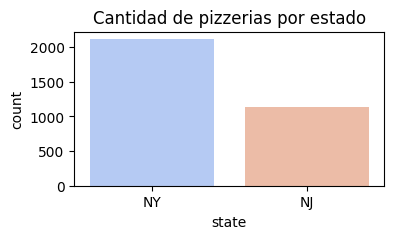

In [ ]:
# Contar el número de pizzerías por estado
state_counts = df_gm_pizza_NJNY['state'].value_counts()

# Imprimir
print("Cantidad de pizzerías por estado:\n", state_counts)

plt.figure(figsize=(4,2))
sns.countplot(data=df_gm_pizza_NJNY, x="state", palette="coolwarm")
plt.title("Cantidad de pizzerias por estado")
plt.show()

Observamos que aparecen datos de 1134 pizzerias en NJ y de 2118 pizzerias en NJ

##### Analizaremos ahora los datos de reviews de Google Maps

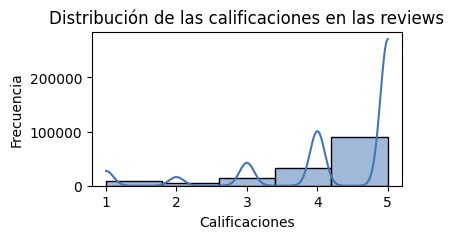

In [45]:
# Distribution of ratings
plt.figure(figsize=(4,2))
sns.histplot(df_gm_pizza_NJNY_rev['rating'], bins=5, kde=True, color='#4575b4')
plt.title("Distribución de las calificaciones en las reviews")
plt.xlabel("Calificaciones")
plt.ylabel("Frecuencia")
plt.show()

En las reviews la mayoría de las pizzerías tienen calificaciones altas, entre 4 y 5.

In [68]:
pizzeria_stats = df_gm_pizza_NJNY_rev.groupby('business_name').agg(
    num_reviews=('rating', 'count'),  # Count reviews
    avg_rating=('rating', 'mean')  # Average rating
).reset_index()

top_pizzeria_stats = pizzeria_stats.sort_values(by='num_reviews', ascending=False).head(10)

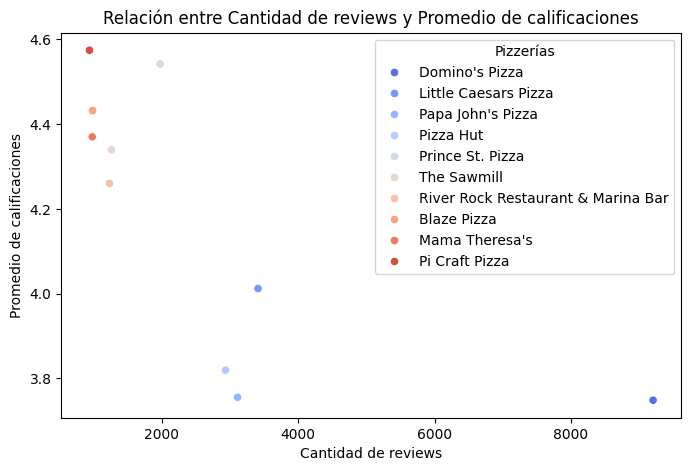

In [76]:
plt.figure(figsize=(8,5))
sns.scatterplot(data= top_pizzeria_stats, x="num_reviews", y="avg_rating", hue="business_name", palette="coolwarm")
plt.title("Relación entre Cantidad de reviews y Promedio de calificaciones")
plt.xlabel("Cantidad de reviews")
plt.ylabel("Promedio de calificaciones")
plt.legend(title="Pizzerías")
plt.show()

Podríamos decir que mayor cantidad de reviews indicarían mas popularidad. Pero pareciera que la relación entre cantidad de reviews y promedio de calificaciones sería inversamente proporcional. La calificación sería menor a mayor cantidad de reviews.

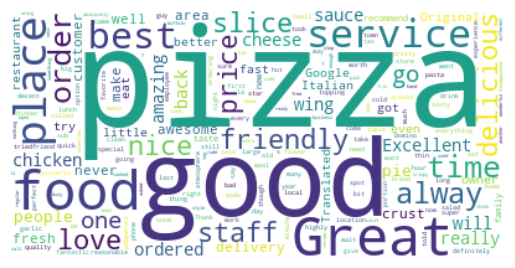

In [82]:
#Creating the text variable

df = df_gm_pizza_NJNY_rev.dropna(subset=['text'])

text2 = " ".join(text for text in df['text'])

# Creating word_cloud with text as argument in .generate() method
word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(text2)

# Display the generated Word Cloud
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

Observamos la nube de palabras creada a partir de los textos de las reviews para todas las pizzerias. se destacan palabras positivas como good, great, nice, friendly, nice, excellent

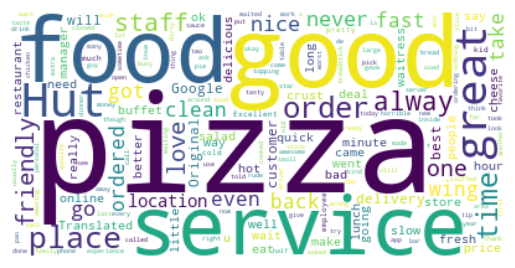

In [83]:
df_hut = df_gm_pizza_NJNY_rev[df_gm_pizza_NJNY_rev['business_name'].isin(['Pizza Hut', 'Pizza Hut Express'])]
df = df_hut.dropna(subset=['text'])

text2 = " ".join(text for text in df['text'])

# Creating word_cloud with text as argument in .generate() method
word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(text2)

# Display the generated Word Cloud
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

Si analizamos solo los textos de las reviews para los locales de Pizza Hut vemos que se destacan palabras positivas como good, great y friendly, como en el gráfico anterior. Y que la palabra service aparece en mayor tamaño.

</br>

#### Datos de Yelp